# Regression Analysis on News Documents
In this notebook, we include all the regression analysis we did using the output of Coh-metrix on a collection of fake and real news documents.

In [1]:
# reading the excel file which includes all the information
library("readxl")
# fakenewsnet_full_un.xlsx is the unprepreocessed version
# fakenewsnet_full.xlsx is the prepreocessed version
my_data <- read_excel("data/FakeNewsNet/old/processed/fakenewsnet_full_un.xlsx")
head(my_data)

X__1,DESPC,DESSC,DESWC,DESPL,DESPLd,DESSL,DESSLd,DESWLsy,DESWLsyd,⋯,WRDHYPv,WRDHYPnv,RDFRE,RDFKGL,RDL2,label,checker,total_shares,shares,id
0,27,83,1714,3.074,1.920,21.036,9.954,1.510,0.869,⋯,1.504,1.710,58.128,10.282,12.778,0,1,1.612784,1.579784,100
1,8,14,263,1.750,1.165,19.286,12.437,1.578,0.957,⋯,1.561,1.608,54.268,10.357,18.416,0,1,1.806180,1.716003,101
2,8,13,247,1.625,1.061,19.231,12.112,1.490,0.821,⋯,1.897,1.801,61.496,9.402,9.294,0,1,1.301030,1.278754,102
3,4,7,119,1.750,0.500,17.143,6.986,1.706,0.995,⋯,1.926,2.151,45.252,11.171,13.503,0,1,1.973128,1.924279,103
4,10,22,432,2.200,1.751,19.955,15.671,1.688,0.920,⋯,1.718,2.274,44.100,11.986,11.865,0,1,1.477121,1.462398,104
5,8,11,235,1.375,0.518,21.818,12.123,1.668,0.983,⋯,2.105,2.560,44.038,12.424,5.850,0,1,2.453318,2.437751,105


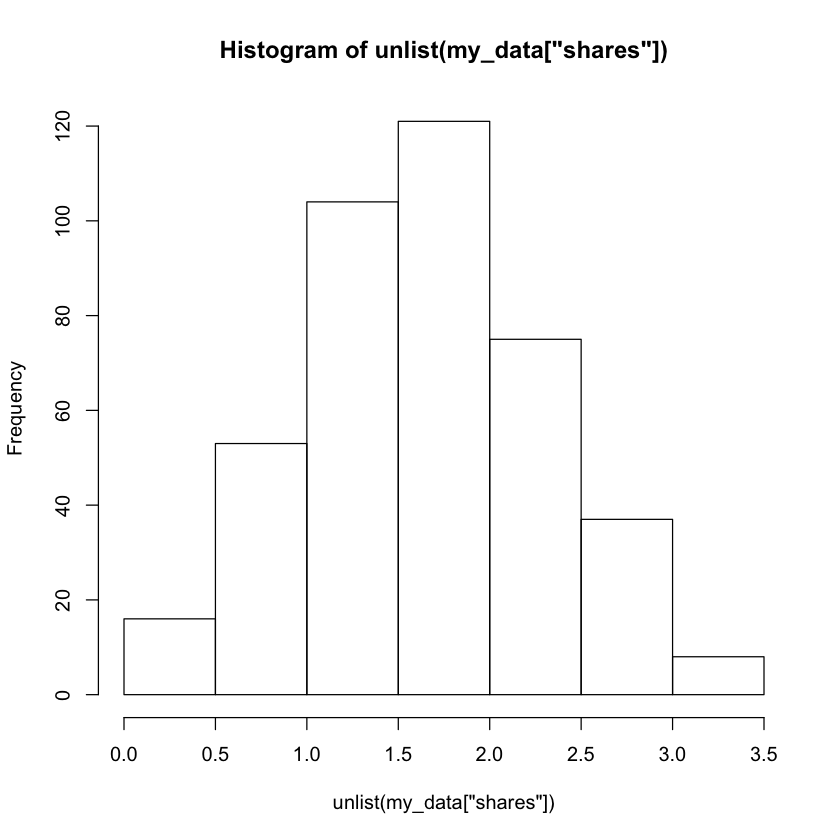

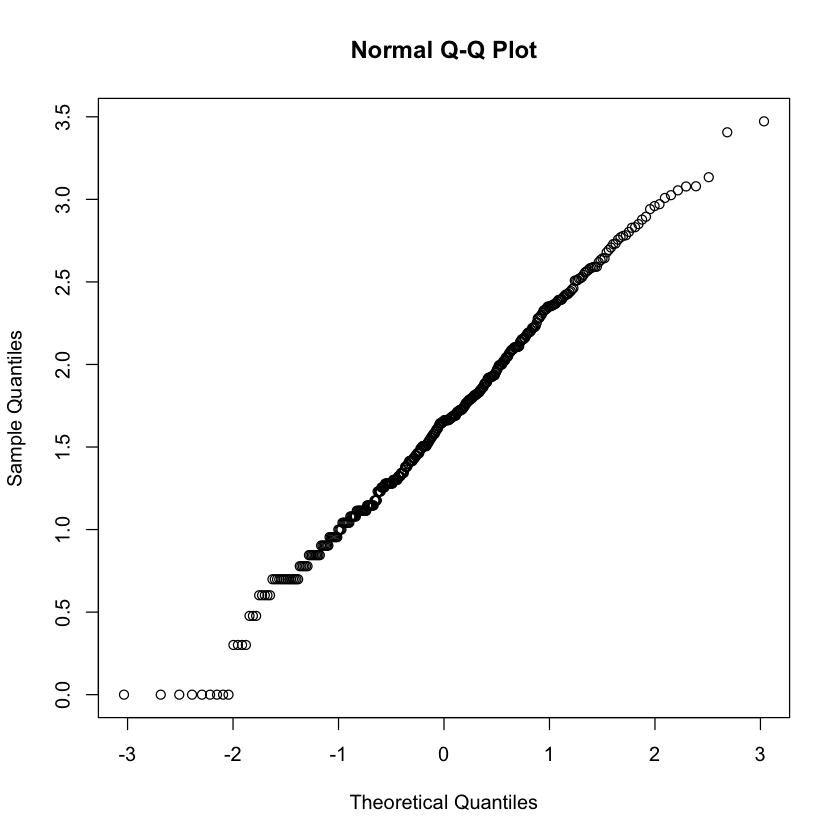

In [2]:
# plotting the normal distribution and probability plot
hist(unlist(my_data["shares"]))
qqnorm(unlist(my_data["shares"]))

## Multiple Linear Regression
In the following cell, we run some linear regression analysis based on text easability and situation model features of Coh-metrix suggested by [1]

In [6]:
# drops <- c("X__1", "id")

text_easability <- c("PCNARz", "PCNARp", "PCSYNz", "PCSYNp", "PCCNCz", "PCCNCp", "PCREFz", "PCREFp", "PCDCz", "PCDCp", "PCVERBz", "PCVERBp", "PCCONNz", "PCCONNp", "PCTEMPz", "PCTEMPp")
situation_model <- c("SMCAUSv", "SMCAUSvp", "SMINTEp", "SMCAUSr", "SMINTEr", "SMCAUSlsa", "SMCAUSwn", "SMTEMP")
# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")

x <- my_data[, (names(my_data) %in% c(text_easability, situation_model))]
y <- my_data["shares"]

lin_model <- lm(unlist(y) ~ ., data=x)
summary(lin_model)


Call:
lm(formula = unlist(y) ~ ., data = x)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70769 -0.43990 -0.02953  0.44327  1.85727 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  3.4116762  2.4792505   1.376   0.1696  
PCNARz       0.1978628  0.3577636   0.553   0.5805  
PCNARp      -0.0096982  0.0109985  -0.882   0.3784  
PCSYNz      -0.0180457  0.2983227  -0.060   0.9518  
PCSYNp      -0.0080688  0.0091515  -0.882   0.3785  
PCCNCz      -0.0815484  0.1802268  -0.452   0.6512  
PCCNCp       0.0001432  0.0059790   0.024   0.9809  
PCREFz       0.3172790  0.1396868   2.271   0.0237 *
PCREFp      -0.0098479  0.0050695  -1.943   0.0528 .
PCDCz       -0.0981213  0.1691102  -0.580   0.5621  
PCDCp        0.0062539  0.0055504   1.127   0.2605  
PCVERBz      0.2664473  0.1525519   1.747   0.0815 .
PCVERBp     -0.0101588  0.0057158  -1.777   0.0763 .
PCCONNz      0.0629740  0.0766334   0.822   0.4117  
PCCONNp     -0.0040386  0.0037557  -1.075

## Principal Component Analysis (PCA)
In this section, we first run a PCA on all the indexes we have from the coh-metrix to reduce the number of features. Then, using the scores from the PCA model, we run a linear regression analysis to find the significant components in predicting the number of shares.

In [15]:
# Principal Component Analysis (PCA)
# ----------------------------------
# to install the "psych" package, uncomment the two following lines:
# options(download.file.method = "wget")
# install.packages("psych")
library("psych")

# dropping the columns that we do not want in the regression analysis.
truth_labels <- my_data["label"]
fact_checker <- my_data["checker"]
drops <- c("X__1", "id", "label", "shares", "total_shares", "checker")
# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")
x <- my_data[, !(names(my_data) %in% c(drops))]
y <- my_data["shares"]

# printing eigenvalues to find the number of components for PCA
# print(eigen(cor(x)))

pca <- psych::principal(x, nfactors=23, rotate="varimax")
# print(pca$loadings, cutoff = 0.4, sort = TRUE)

# linear regression using the PCA scores
lin_model <- lm(unlist(y) ~ pca$scores + as.matrix(truth_labels) + as.matrix(fact_checker))
summary(lin_model)
write.csv(pca$loadings, "data/FakeNewsNet/old/processed/pca_loadings.csv")


Call:
lm(formula = unlist(y) ~ pca$scores + as.matrix(truth_labels) + 
    as.matrix(fact_checker))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67380 -0.40458  0.00365  0.41753  1.81359 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.465145   0.117815  12.436  < 2e-16 ***
pca$scoresRC1           -0.040477   0.032447  -1.247  0.21297    
pca$scoresRC2            0.089744   0.032357   2.774  0.00581 ** 
pca$scoresRC3           -0.034917   0.032233  -1.083  0.27936    
pca$scoresRC6           -0.013471   0.032820  -0.410  0.68169    
pca$scoresRC5           -0.031616   0.032453  -0.974  0.33056    
pca$scoresRC4           -0.036726   0.032065  -1.145  0.25277    
pca$scoresRC7            0.066947   0.033159   2.019  0.04418 *  
pca$scoresRC9            0.001648   0.032357   0.051  0.95942    
pca$scoresRC20          -0.037479   0.032057  -1.169  0.24308    
pca$scoresRC22           0.019094   0.032090   0.595  

## Cross validation
In this section, we train our linear regression models using three methods of cross validation.

In [20]:
# K-fold cross-validation for linear regression
# ----------------------------------------------
# to install the "caret" package, uncomment the two following lines:
# options(download.file.method = "wget")
# install.packages("caret")
library(caret)

drops <- c("X__1", "id", "total_shares")
# text_easability <- c("PCNARz", "PCNARp", "PCSYNz", "PCSYNp", "PCCNCz", "PCCNCp", "PCREFz", "PCREFp", "PCDCz", "PCDCp", "PCVERBz", "PCVERBp", "PCCONNz", "PCCONNp", "PCTEMPz", "PCTEMPp")
# situation_model <- c("SMCAUSv", "SMCAUSvp", "SMINTEp", "SMCAUSr", "SMINTEr", "SMCAUSlsa", "SMCAUSwn", "SMTEMP")
# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")
x <- my_data[, !(names(my_data) %in% c(drops))]

set.seed(123)
# three different setup for cross validation
# train.control <- trainControl(method = "LOOCV")
train.control <- trainControl(method = "cv", number = 5)
# train.control <- trainControl(method = "repeatedcv", number = 10)
lin_model <- train(shares ~ ., data=x, method = "lm", trControl = train.control)
print(lin_model)
summary(lin_model)

Linear Regression 

414 samples
110 predictors

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 333, 331, 330, 330, 332 
Resampling results:

  RMSE       Rsquared    MAE      
  0.7701568  0.04189545  0.6081193

Tuning parameter 'intercept' was held constant at a value of TRUE



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.68431 -0.35294 -0.01604  0.36580  1.58934 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.244e+03  7.808e+03  -0.159 0.873576    
DESPC        2.718e-04  1.077e-02   0.025 0.979893    
DESSC        9.332e-03  8.487e-03   1.099 0.272425    
DESWC       -3.091e-04  3.811e-04  -0.811 0.417848    
DESPL       -3.884e-02  8.536e-02  -0.455 0.649455    
DESPLd      -1.013e-01  8.406e-02  -1.205 0.229090    
DESSL       -8.419e-01  1.970e+00  -0.427 0.669434    
DESSLd       3.277e-03  1.716e-02   0.191 0.848705    
DESWLsy      7.522e+02  2.478e+03   0.303 0.761735    
DESWLsyd     2.321e+00  1.018e+00   2.281 0.023270 *  
DESWLlt     -2.575e-02  4.488e-01  -0.057 0.954279    
DESWLltd    -9.832e-01  3.073e-01  -3.200 0.001522 ** 
PCNARz       9.575e+01  6.895e+01   1.389 0.165938    
PCNARp       1.873e-02  1.410e-02   1.329 0.184996    
PCSYNz    

## Stepwise linear regression
We also did a stepwise backward linear regression to eliminate insignificant features from our model. As it is shown in our results, causal verb and causal particles show up as significant predictors in our linear regression model. 

AIC stands for Akaike information criterion which is an estimator of the relative quality of statistical models for a given set of data. Generally, a lower value for AIC mean a model better. There is a $<none>$ feature listed among the other features in the output. As it can be seen, if we eliminate any feature above $<none>$, the AIC value will be lower which means elimination of that feature is good for our model. And, if we remove any feature below $<none>$, the AIC will be larger which means removing the features below $<none>$ is not good for our model.

### Backward

In [27]:
# Stepwise linear regression - backward
drops <- c("X__1", "id", "total_shares")

# paragraph_features <- c("DESPC", "DESPL", "DESPLd", "LSAPP1", "LSAPP1d", "SYNSTRUTt")
# text_easability <- c("PCNARz", "PCNARp", "PCSYNz", "PCSYNp", "PCCNCz", "PCCNCp", "PCREFz", "PCREFp", "PCDCz", "PCDCp", "PCVERBz", "PCVERBp", "PCCONNz", "PCCONNp", "PCTEMPz", "PCTEMPp")
# situation_model <- c("SMCAUSv", "SMCAUSvp", "SMINTEp", "SMCAUSr", "SMINTEr", "SMCAUSlsa", "SMCAUSwn", "SMTEMP")
# labels <- c("label", "checker", "shares")

# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")
x <- my_data[, !(names(my_data) %in% c(drops))]
# x <- my_data[, (names(my_data) %in% c(text_easability, situation_model, labels))]

# a lower value of AIC suggests "better" model
lin_model <- lm(shares ~ ., data=x)
formula(lin_model)
summary(step(lin_model, direction = "backward"))

shares ~ DESPC + DESSC + DESWC + DESPL + DESPLd + DESSL + DESSLd + 
    DESWLsy + DESWLsyd + DESWLlt + DESWLltd + PCNARz + PCNARp + 
    PCSYNz + PCSYNp + PCCNCz + PCCNCp + PCREFz + PCREFp + PCDCz + 
    PCDCp + PCVERBz + PCVERBp + PCCONNz + PCCONNp + PCTEMPz + 
    PCTEMPp + CRFNO1 + CRFAO1 + CRFSO1 + CRFNOa + CRFAOa + CRFSOa + 
    CRFCWO1 + CRFCWO1d + CRFCWOa + CRFCWOad + CRFANP1 + CRFANPa + 
    LSASS1 + LSASS1d + LSASSp + LSASSpd + LSAPP1 + LSAPP1d + 
    LSAGN + LSAGNd + LDTTRc + LDTTRa + LDMTLD + LDVOCD + CNCAll + 
    CNCCaus + CNCLogic + CNCADC + CNCTemp + CNCTempx + CNCAdd + 
    CNCPos + CNCNeg + SMCAUSv + SMCAUSvp + SMINTEp + SMCAUSr + 
    SMINTEr + SMCAUSlsa + SMCAUSwn + SMTEMP + SYNLE + SYNNP + 
    SYNMEDpos + SYNMEDwrd + SYNMEDlem + SYNSTRUTa + SYNSTRUTt + 
    DRNP + DRVP + DRAP + DRPP + DRPVAL + DRNEG + DRGERUND + DRINF + 
    WRDNOUN + WRDVERB + WRDADJ + WRDADV + WRDPRO + WRDPRP1s + 
    WRDPRP1p + WRDPRP2 + WRDPRP3s + WRDPRP3p + WRDFRQc + WRDFRQa + 
    WRDFRQmc + 

Start:  AIC=-305.9
shares ~ DESPC + DESSC + DESWC + DESPL + DESPLd + DESSL + DESSLd + 
    DESWLsy + DESWLsyd + DESWLlt + DESWLltd + PCNARz + PCNARp + 
    PCSYNz + PCSYNp + PCCNCz + PCCNCp + PCREFz + PCREFp + PCDCz + 
    PCDCp + PCVERBz + PCVERBp + PCCONNz + PCCONNp + PCTEMPz + 
    PCTEMPp + CRFNO1 + CRFAO1 + CRFSO1 + CRFNOa + CRFAOa + CRFSOa + 
    CRFCWO1 + CRFCWO1d + CRFCWOa + CRFCWOad + CRFANP1 + CRFANPa + 
    LSASS1 + LSASS1d + LSASSp + LSASSpd + LSAPP1 + LSAPP1d + 
    LSAGN + LSAGNd + LDTTRc + LDTTRa + LDMTLD + LDVOCD + CNCAll + 
    CNCCaus + CNCLogic + CNCADC + CNCTemp + CNCTempx + CNCAdd + 
    CNCPos + CNCNeg + SMCAUSv + SMCAUSvp + SMINTEp + SMCAUSr + 
    SMINTEr + SMCAUSlsa + SMCAUSwn + SMTEMP + SYNLE + SYNNP + 
    SYNMEDpos + SYNMEDwrd + SYNMEDlem + SYNSTRUTa + SYNSTRUTt + 
    DRNP + DRVP + DRAP + DRPP + DRPVAL + DRNEG + DRGERUND + DRINF + 
    WRDNOUN + WRDVERB + WRDADJ + WRDADV + WRDPRO + WRDPRP1s + 
    WRDPRP1p + WRDPRP2 + WRDPRP3s + WRDPRP3p + WRDFRQc + WRDFRQa


Call:
lm(formula = shares ~ DESSC + DESPLd + DESWLsy + DESWLsyd + DESWLltd + 
    PCNARz + PCNARp + PCSYNz + PCCNCz + PCREFz + PCREFp + PCDCz + 
    PCVERBz + PCCONNz + PCTEMPz + CRFNO1 + CRFAO1 + CRFSO1 + 
    CRFAOa + CRFSOa + CRFCWOa + CRFANP1 + LSASS1 + LSAPP1d + 
    LSAGN + LDTTRc + LDMTLD + LDVOCD + CNCAll + CNCCaus + CNCLogic + 
    CNCADC + CNCTemp + CNCAdd + SMCAUSr + SMINTEr + SMCAUSlsa + 
    SMCAUSwn + SMTEMP + SYNLE + SYNNP + SYNMEDpos + SYNMEDwrd + 
    SYNMEDlem + SYNSTRUTa + DRNP + DRPP + DRPVAL + DRNEG + WRDNOUN + 
    WRDADJ + WRDADV + WRDPRO + WRDPRP1s + WRDPRP1p + WRDPRP3s + 
    WRDPRP3p + WRDFRQc + WRDFRQa + WRDFRQmc + WRDAOAc + WRDFAMc + 
    WRDCNCc + WRDIMGc + WRDMEAc + WRDPOLc + WRDHYPnv + RDFKGL + 
    RDL2 + label, data = x)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66434 -0.36384 -0.05765  0.41207  1.57481 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.097e+02  1.247e+02   4.088 5.43e-05 ***
DESSC 

### Forward

In [28]:
# Stepwise linear regression - forward
drops <- c("X__1", "id", "total_shares")
# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")
x <- my_data[, !(names(my_data) %in% c(drops))]

# a lower value of AIC suggests "better" model
fit_start <- lm(shares ~ 1, data=x)
fit_all <- lm(shares ~ ., data=x)
summary(step(fit_start, direction = "forward", scope=formula(fit_all)))

Start:  AIC=-340.26
shares ~ 1

            Df Sum of Sq    RSS     AIC
+ DRPP       1    4.7140 176.40 -349.18
+ CRFAOa     1    3.8206 177.30 -347.09
+ label      1    3.4228 177.69 -346.16
+ DRAP       1    3.2447 177.87 -345.75
+ CRFSOa     1    3.2022 177.91 -345.65
+ CRFNOa     1    3.0313 178.09 -345.25
+ PCSYNz     1    2.8574 178.26 -344.85
+ RDFKGL     1    2.8069 178.31 -344.73
+ PCSYNp     1    2.6921 178.42 -344.46
+ WRDADV     1    2.6067 178.51 -344.27
+ PCREFz     1    2.4483 178.67 -343.90
+ CRFAO1     1    2.4220 178.69 -343.84
+ WRDPRP1p   1    2.4001 178.72 -343.79
+ DESSL      1    2.3620 178.75 -343.70
+ RDFRE      1    2.1377 178.98 -343.18
+ WRDFAMc    1    2.0876 179.03 -343.06
+ CNCTemp    1    1.9276 179.19 -342.69
+ WRDADJ     1    1.8875 179.23 -342.60
+ SYNMEDpos  1    1.8171 179.30 -342.44
+ CRFSO1     1    1.6472 179.47 -342.05
+ CRFNO1     1    1.5807 179.54 -341.89
+ LSASS1     1    1.4813 179.63 -341.66
+ DRNP       1    1.4457 179.67 -341.58
+ WRDPRP


Call:
lm(formula = shares ~ DRPP + label + WRDPRP1p + CRFAOa + DRAP + 
    WRDMEAc + WRDHYPnv + WRDFRQc + LSAPP1d + DESWLltd + DESWLsyd + 
    WRDPRP2 + DESPC + SMCAUSwn + WRDFRQmc + WRDHYPn + WRDPRP3p + 
    CRFNOa + CRFSO1 + SYNMEDpos + DRNP, data = x)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.39368 -0.39076 -0.03937  0.41908  1.67721 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.884198   1.544021   4.459 1.08e-05 ***
DRPP         0.006095   0.002006   3.039 0.002536 ** 
label        0.318252   0.067873   4.689 3.80e-06 ***
WRDPRP1p     0.010629   0.003687   2.883 0.004156 ** 
CRFAOa      -0.086766   0.467180  -0.186 0.852759    
DRAP        -0.010367   0.002886  -3.592 0.000370 ***
WRDMEAc     -0.006216   0.002307  -2.695 0.007349 ** 
WRDHYPnv    -0.811480   0.179291  -4.526 7.98e-06 ***
WRDFRQc     -0.937092   0.287929  -3.255 0.001234 ** 
LSAPP1d     -1.236996   0.495734  -2.495 0.012996 *  
DESWLltd    -1.086098   0.21263

## Penalized regression (LASSO)
Since we have more than 100 Coh-metrix features in our input data, in addition to PCA --which is a dimensionality reduction method--, we wanted to test a model selection method to reduce the effect of insignificant variables in our linear regression models. To achieve our goal, we used a LASSO regression.

In [29]:
# LASSO model
# install.packages("magrittr") # only needed the first time you use it
# install.packages("dplyr")    # alternative installation of the %>%
library(magrittr) # need to run every time you start R and want to use %>%
# library(dplyr)
library(glmnet)

drops <- c("X__1", "id", "total_shares")
# descriptive <- c("DESPC", "DESSC", "DESWC", "DESPL", "DESPLd", "DESSL", "DESSLd", "DESWLsy", "DESWLsyd", "DESWLlt", "DESWLltd")
x_init <- my_data[, !(names(my_data) %in% c(drops))]

# --------------------------------------
# split the data into train and test set
set.seed(123)
training.samples <- x_init$shares %>% createDataPartition(p = 0.8, list = FALSE)
train.data <- x_init[training.samples, ]
test.data <- x_init[-training.samples, ]

# predictor variables
x <- model.matrix(shares ~ ., train.data)[,-1]
# outcome variable
y <- train.data$shares

# --------------------------------------
# fitting the model

# set the seed for reproducibility
set.seed(123)
cv <- cv.glmnet(x, y, alpha = 1)

# display the best lambda value
cv$lambda.min

# fit the final model
model <- glmnet(x, y, alpha = 1, lambda = cv$lambda.min)

# display regression coefficients
coef(model)

# --------------------------------
# make prediction on the test data
x.test <- model.matrix(shares ~ ., test.data)[,-1]
predictions <- model %>% predict(x.test) %>% as.vector()

# -------------------------
# model performance metrics
data.frame(
    RMSE = RMSE(predictions, test.data$shares),
    Rsquare = R2(predictions, test.data$shares)
)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



[1] 0.1053971

111 x 1 sparse Matrix of class "dgCMatrix"
                  s0
(Intercept) 1.645434
DESPC       0.000000
DESSC       .       
DESWC       .       
DESPL       .       
DESPLd      .       
DESSL       .       
DESSLd      .       
DESWLsy     .       
DESWLsyd    .       
DESWLlt     .       
DESWLltd    .       
PCNARz      .       
PCNARp      .       
PCSYNz      .       
PCSYNp      .       
PCCNCz      .       
PCCNCp      .       
PCREFz      .       
PCREFp      .       
PCDCz       .       
PCDCp       .       
PCVERBz     .       
PCVERBp     .       
PCCONNz     .       
PCCONNp     .       
PCTEMPz     .       
PCTEMPp     .       
CRFNO1      .       
CRFAO1      .       
CRFSO1      .       
CRFNOa      .       
CRFAOa      .       
CRFSOa      .       
CRFCWO1     .       
CRFCWO1d    .       
CRFCWOa     .       
CRFCWOad    .       
CRFANP1     .       
CRFANPa     .       
LSASS1      .       
LSASS1d     .       
LSASSp      .       
LSASSpd     .       
LSAPP1      

Warning message in cor(obs, pred, use = ifelse(na.rm, "complete.obs", "everything")):
“the standard deviation is zero”

RMSE,Rsquare
0.6647684,NA


# Principal Components Regression (PCR)

Data: 	X dimension: 414 110 
	Y dimension: 414 1
Fit method: svdpc
Number of components considered: 110

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           0.663   0.6617   0.6622   0.6634   0.6632   0.6650   0.6660
adjCV        0.663   0.6615   0.6619   0.6630   0.6627   0.6643   0.6654
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV      0.6691   0.6698   0.6710    0.6715    0.6736    0.6741    0.6763
adjCV   0.6682   0.6689   0.6701    0.6704    0.6726    0.6732    0.6754
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps  20 comps
CV       0.6747    0.6753    0.6761    0.6760    0.6794    0.6846    0.6867
adjCV    0.6729    0.6740    0.6749    0.6741    0.6775    0.6827    0.6848
       21 comps  22 comps  23 comps  24 comps  25 comps  26 comps  27 comps
CV       0.6875    0.6914    0.6917    0.6914    0.6938    0.6913    0.6890
adjCV    0.6857  

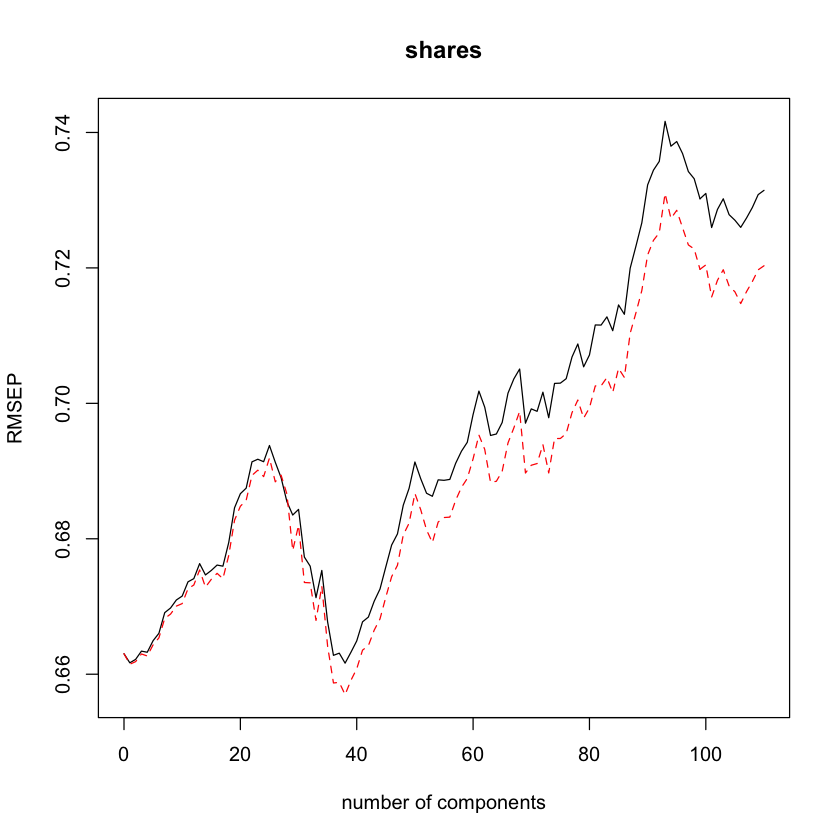

In [31]:
require(pls)
drops <- c("X__1", "id", "total_shares")
x <- my_data[, !(names(my_data) %in% c(drops))]

set.seed (1000)
pcr_model <- pcr(shares ~ ., data = x, scale = TRUE, validation = "CV")
summary(pcr_model)

# Plot the root mean squared error
validationplot(pcr_model)

## References
[1] Wolfe, Christopher R., et al. "A Method for Automatically Analyzing Intelligent Tutoring System Dialogues with Coh-Metrix." Journal of Learning Analytics 5.3 (2018): 222-234.